## Utils

In [1]:
import torch
import numpy as np
import random

In [2]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(42)
random.seed(42)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
import matplotlib.pyplot as plt

def plot_scalars(ys, xs=None, y_name='loss', x_name='epoch'):
  if xs is None:
    xs = range(1, len(ys)+1)
  plt.plot(xs, ys)
  plt.xlabel(x_name)
  plt.ylabel(y_name)
  plt.title(f"{y_name} vs {x_name}")
  plt.show()

In [5]:
def train(data_loader, model, loss_fn, optimizer, n_epochs):
  model.to(device)
  model.train()
  losses = []
  for i in range(n_epochs):
    epoch_loss = 0.0
    for batch, (x, y) in enumerate(data_loader):
      x, y = x.to(device), y.to(device)
      logits = model(x)
      loss = loss_fn(logits, y)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      epoch_loss += loss.item()
    losses.append(epoch_loss / len(data_loader))
    print(f"[Epoch {i+1}] Loss: {losses[-1]}")
  return losses

In [6]:
def display_predictions(models, ds, n_samples=4):
    random_indices = random.sample(range(len(ds)), n_samples)
    n_models = len(models)

    fig, axes = plt.subplots(n_models, n_samples, figsize=(n_samples * 3, n_models * 3))

    for model in models:
        model.eval()

    with torch.no_grad():
        for row, model in enumerate(models):
            for col, index in enumerate(random_indices):
                image, label = ds[index]
                image = image.to(device)

                prediction = model(image)
                predicted_class = torch.argmax(prediction, dim=1).item()

                ax = axes[row, col] if n_models > 1 else axes[col]
                ax.imshow(image.cpu().squeeze(0), cmap='gray')
                ax.axis('off')
                ax.set_title(f"Pred: {predicted_class}\nActual: {label}")

    plt.tight_layout()
    plt.show()

## Exercise 1 - Get MNIST

In [7]:
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

In [8]:
mnist_ds = MNIST(
  root='data',
  download=True,
  transform=ToTensor(),
)

100.0%
100.0%
100.0%
100.0%


## Exercise 2 - Train a Simple DNN

In [9]:
from torch.utils.data import random_split

In [10]:
n_train = int(0.6 * len(mnist_ds))
n_test = len(mnist_ds) - n_train

In [11]:
train_ds, test_ds = random_split(mnist_ds, [n_train, n_test])

In [12]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

In [13]:
import torch

In [14]:
class SimpleDNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.input_dim = 784
    self.output_dim = 10
    self.net = torch.nn.Sequential(
        torch.nn.Linear(self.input_dim, 256),
        torch.nn.ReLU(),
        torch.nn.Linear(256, self.output_dim)
    )

  def forward(self, x):
    x = x.flatten(start_dim=1)
    logits = self.net(x)
    return logits

In [15]:
simple_dnn = SimpleDNN()

In [16]:
n_epochs = 30
loss_fn = torch.nn.CrossEntropyLoss() # applies softmax internally, expects logits
optimizer = torch.optim.SGD(simple_dnn.parameters(), lr=1e-3)

In [17]:
losses = train(train_loader, simple_dnn, loss_fn, optimizer, n_epochs)

[Epoch 1] Loss: 2.1903728957706026
[Epoch 2] Loss: 1.8991058053970338
[Epoch 3] Loss: 1.527515631781684
[Epoch 4] Loss: 1.1930712843471103
[Epoch 5] Loss: 0.9610515279240078
[Epoch 6] Loss: 0.8116888680722978
[Epoch 7] Loss: 0.712371961010827
[Epoch 8] Loss: 0.6427782303227318
[Epoch 9] Loss: 0.5915194527308146
[Epoch 10] Loss: 0.5521374295817482
[Epoch 11] Loss: 0.5210468817022111
[Epoch 12] Loss: 0.4959527306424247
[Epoch 13] Loss: 0.47522141545348695
[Epoch 14] Loss: 0.4577574405140347
[Epoch 15] Loss: 0.4430202287700441
[Epoch 16] Loss: 0.43021837057007684
[Epoch 17] Loss: 0.4190671711895201
[Epoch 18] Loss: 0.4092765267160204
[Epoch 19] Loss: 0.40062263764275446
[Epoch 20] Loss: 0.39282730481359696
[Epoch 21] Loss: 0.38573254467381374
[Epoch 22] Loss: 0.379369616303179
[Epoch 23] Loss: 0.3735275419685576
[Epoch 24] Loss: 0.368082045144505
[Epoch 25] Loss: 0.36313454523351457
[Epoch 26] Loss: 0.35842369159062704
[Epoch 27] Loss: 0.35418043306801056
[Epoch 28] Loss: 0.35010282772779

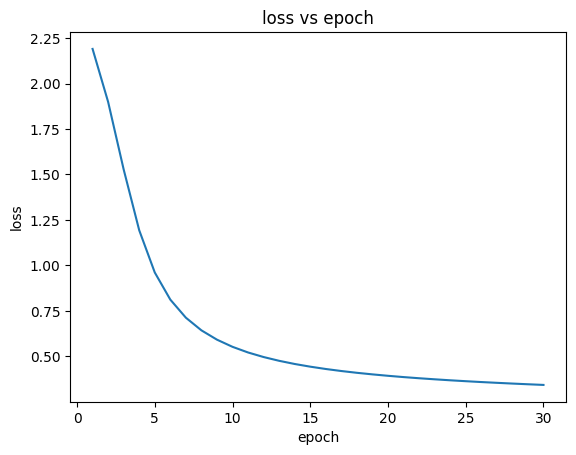

In [18]:
plot_scalars(losses)

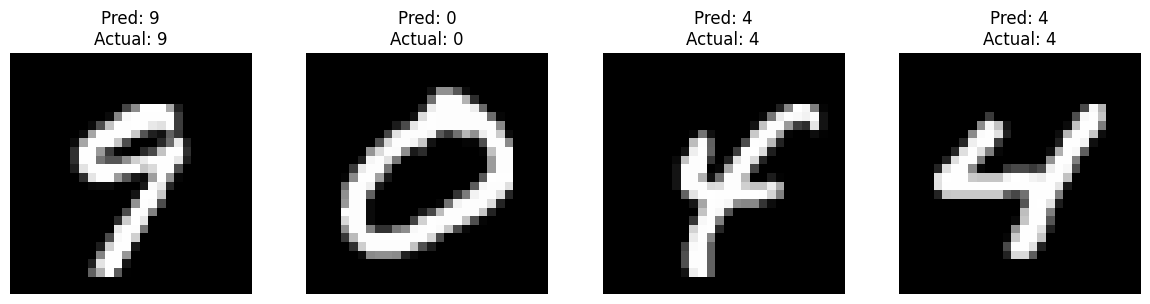

In [19]:
display_predictions([simple_dnn], test_ds)

## Exercise 3 - Experiment with Different Architectures

In [20]:
def evaluate_accuracy(model, data_loader):
  model.to(device)
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for x, y in data_loader:
      x, y = x.to(device), y.to(device)
      logits = model(x)
      predictions = torch.argmax(logits, dim=1)
      correct += (predictions == y).sum().item()
      total += y.size(0)
  return correct / total

In [21]:
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [22]:
class ReLUSimpleDNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(784, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 10)
        )

    def forward(self, x):
        x = x.flatten(start_dim=1)
        logits = self.net(x)
        return logits

[Epoch 1] Loss: 2.2036603707207574
[Epoch 2] Loss: 1.9399966169993084
[Epoch 3] Loss: 1.6121776953803169
[Epoch 4] Loss: 1.298180597888099
[Epoch 5] Loss: 1.0559089081022475
[Epoch 6] Loss: 0.8895577730072869
[Epoch 7] Loss: 0.7755889074537489
[Epoch 8] Loss: 0.6947152048481835
[Epoch 9] Loss: 0.635081936094496
[Epoch 10] Loss: 0.5893993558618758
[Epoch 11] Loss: 0.5534901324245665
[Epoch 12] Loss: 0.5244951233334012
[Epoch 13] Loss: 0.5006936266687181
[Epoch 14] Loss: 0.48074009982744853
[Epoch 15] Loss: 0.463841761469841
[Epoch 16] Loss: 0.4491845988697476
[Epoch 17] Loss: 0.4364826643533177
[Epoch 18] Loss: 0.425347522854805
[Epoch 19] Loss: 0.41541903762022653
[Epoch 20] Loss: 0.4066273055871328
[Epoch 21] Loss: 0.398600446873241
[Epoch 22] Loss: 0.3915221246812079
[Epoch 23] Loss: 0.3849605874286758
[Epoch 24] Loss: 0.3789628259076013
[Epoch 25] Loss: 0.37339968687958186
[Epoch 26] Loss: 0.3683233065605164
[Epoch 27] Loss: 0.36355589193767973
[Epoch 28] Loss: 0.35912734483347997
[

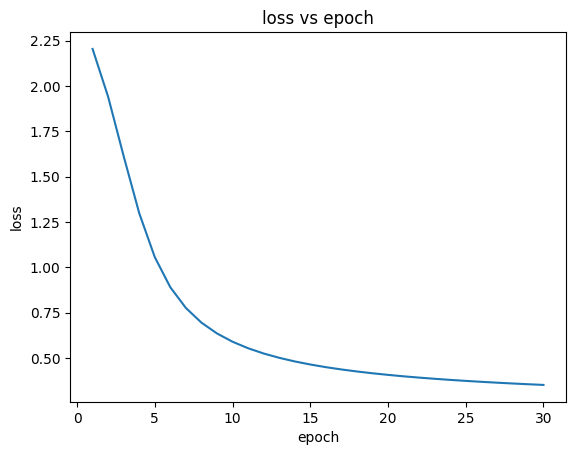

In [23]:
relu_simple_dnn = ReLUSimpleDNN()
loss_fn = torch.nn.CrossEntropyLoss() # applies softmax internally, expects logits
optimizer = torch.optim.SGD(relu_simple_dnn.parameters(), lr=1e-3)
losses = train(train_loader, relu_simple_dnn, loss_fn, optimizer, n_epochs)
plot_scalars(losses)
accuracy_relu_simple_dnn = evaluate_accuracy(relu_simple_dnn, test_loader)

In [24]:
class ReLUComplexDNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.input_dim = 784
        self.output_dim = 10
        self.net = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim, 300),
            torch.nn.ReLU(),
            torch.nn.Linear(300, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, self.output_dim)
        )

    def forward(self, x):
        x = x.flatten(start_dim=1)
        logits = self.net(x)
        return logits

[Epoch 1] Loss: 2.3034404356214737
[Epoch 2] Loss: 2.2969669859144424
[Epoch 3] Loss: 2.2896456292470297
[Epoch 4] Loss: 2.280459832297431
[Epoch 5] Loss: 2.2677192090352376
[Epoch 6] Loss: 2.248818372302585
[Epoch 7] Loss: 2.2190980468326145
[Epoch 8] Loss: 2.167180190616184
[Epoch 9] Loss: 2.069114888191223
[Epoch 10] Loss: 1.879996573554145
[Epoch 11] Loss: 1.5748161476982965
[Epoch 12] Loss: 1.242487180074056
[Epoch 13] Loss: 0.9856315511597528
[Epoch 14] Loss: 0.8147020093599955
[Epoch 15] Loss: 0.6988189431031545
[Epoch 16] Loss: 0.6177522097958459
[Epoch 17] Loss: 0.5600713586144977
[Epoch 18] Loss: 0.5183209378984239
[Epoch 19] Loss: 0.48668111324310304
[Epoch 20] Loss: 0.46251699346303937
[Epoch 21] Loss: 0.44342526388168335
[Epoch 22] Loss: 0.42774297412236534
[Epoch 23] Loss: 0.41477738594346575
[Epoch 24] Loss: 0.4039349051382807
[Epoch 25] Loss: 0.3945362749828233
[Epoch 26] Loss: 0.3862988855176502
[Epoch 27] Loss: 0.3789671641919348
[Epoch 28] Loss: 0.3722512319750256
[E

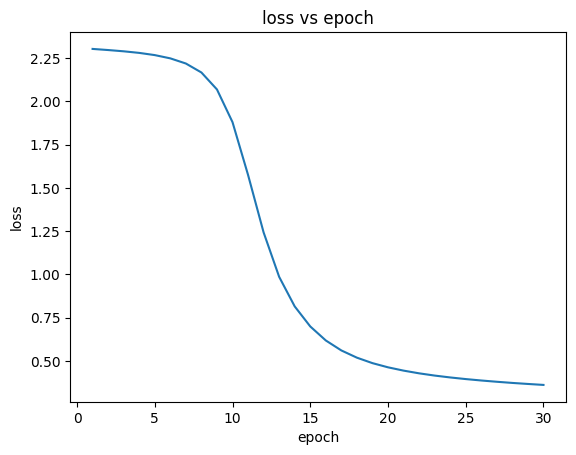

In [25]:
relu_complex_dnn = ReLUComplexDNN()
loss_fn = torch.nn.CrossEntropyLoss() # applies softmax internally, expects logits
optimizer = torch.optim.SGD(relu_complex_dnn.parameters(), lr=1e-3)
losses = train(train_loader, relu_complex_dnn, loss_fn, optimizer, n_epochs)
plot_scalars(losses)
accuracy_relu_complex_dnn = evaluate_accuracy(relu_complex_dnn, test_loader)

In [26]:
class SigmoidDNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.input_dim = 784
        self.output_dim = 10
        self.net = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim, 256),
            torch.nn.Sigmoid(),
            torch.nn.Linear(256, 128),
            torch.nn.Sigmoid(),
            torch.nn.Linear(128, self.output_dim)
        )

    def forward(self, x):
        x = x.flatten(start_dim=1)
        logits = self.net(x)
        return logits


[Epoch 1] Loss: 2.3007087542215983
[Epoch 2] Loss: 2.2911945480770535
[Epoch 3] Loss: 2.2754862287309434
[Epoch 4] Loss: 2.2397900659773087
[Epoch 5] Loss: 2.1349258886973064
[Epoch 6] Loss: 1.8547513759401109
[Epoch 7] Loss: 1.5126369875801935
[Epoch 8] Loss: 1.26531510119968
[Epoch 9] Loss: 1.0679901961750455
[Epoch 10] Loss: 0.9256078943676419
[Epoch 11] Loss: 0.8253544513119592
[Epoch 12] Loss: 0.7471812057230207
[Epoch 13] Loss: 0.681707594871521
[Epoch 14] Loss: 0.6269828525119358
[Epoch 15] Loss: 0.581603896247016
[Epoch 16] Loss: 0.5442922168837653
[Epoch 17] Loss: 0.5140153645277024
[Epoch 18] Loss: 0.4886261900862058
[Epoch 19] Loss: 0.4681295183499654
[Epoch 20] Loss: 0.4506781792243322
[Epoch 21] Loss: 0.43578184290064703
[Epoch 22] Loss: 0.42305123511950177
[Epoch 23] Loss: 0.4117482038471434
[Epoch 24] Loss: 0.4018034380012088
[Epoch 25] Loss: 0.39251305798689523
[Epoch 26] Loss: 0.3846478320095274
[Epoch 27] Loss: 0.3773140098585023
[Epoch 28] Loss: 0.3702989306251208
[E

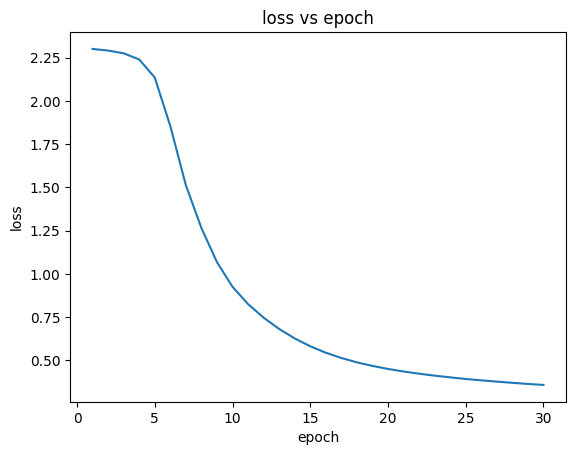

In [27]:
sigmoid_dnn = SigmoidDNN()
loss_fn = torch.nn.CrossEntropyLoss() # applies softmax internally, expects logits
optimizer = torch.optim.SGD(sigmoid_dnn.parameters(), lr=1e-2) # suspect gradients are small because of sigmoid, so increased learning rate
losses = train(train_loader, sigmoid_dnn, loss_fn, optimizer, n_epochs)
plot_scalars(losses)
accuracy_sigmoid_dnn = evaluate_accuracy(sigmoid_dnn, test_loader)

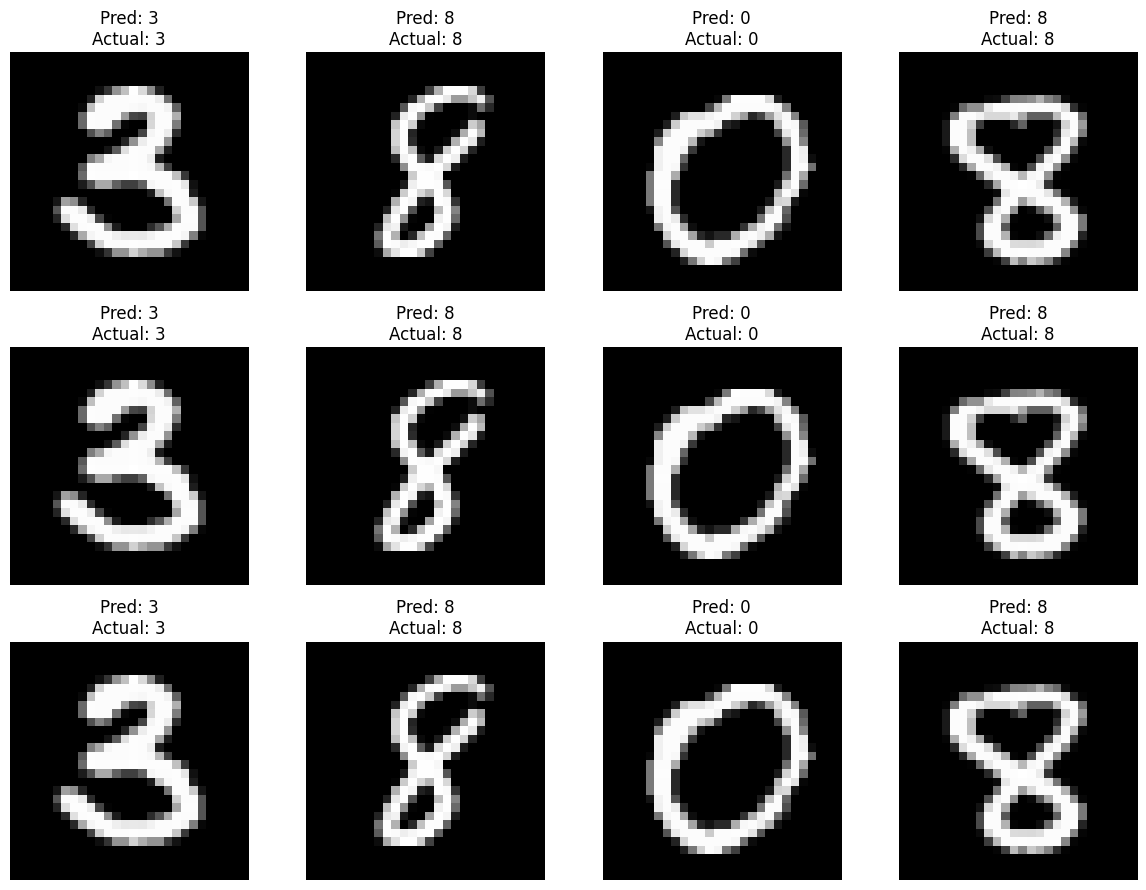

Accuracy of ReLUSimpleDNN: 0.8970833333333333
Accuracy of ReLUComplexDNN: 0.893
Accuracy of SigmoidDNN: 0.8926666666666667


In [28]:
display_predictions([relu_simple_dnn, relu_complex_dnn, sigmoid_dnn], test_ds)

print(f"Accuracy of ReLUSimpleDNN: {accuracy_relu_simple_dnn}")
print(f"Accuracy of ReLUComplexDNN: {accuracy_relu_complex_dnn}")
print(f"Accuracy of SigmoidDNN: {accuracy_sigmoid_dnn}")

In [29]:
import numpy as np
epsilons = np.power(10.0, [x for x in np.linspace(-9, 0, 20)])
epsilons

array([1.00000000e-09, 2.97635144e-09, 8.85866790e-09, 2.63665090e-08,
       7.84759970e-08, 2.33572147e-07, 6.95192796e-07, 2.06913808e-06,
       6.15848211e-06, 1.83298071e-05, 5.45559478e-05, 1.62377674e-04,
       4.83293024e-04, 1.43844989e-03, 4.28133240e-03, 1.27427499e-02,
       3.79269019e-02, 1.12883789e-01, 3.35981829e-01, 1.00000000e+00])

In [30]:
noise = np.random.rand(28, 28)

In [31]:
from torchvision.transforms import v2
from torchvision.transforms import Compose

class FixedNoiseTransform(torch.nn.Module):
    def __init__(self, noise, epsilon=0.1):
        super().__init__()
        self.noise = noise
        self.epsilon = epsilon

    def forward(self, x):
        return (x.float() + self.epsilon * self.noise).float()

In [32]:
def evaluate_robustness(model, noise, epsilons, ds):
  accs = []
  for epsilon in epsilons:
    transform = FixedNoiseTransform(noise, epsilon)
    noisy_ds = [(transform(img), label) for img, label in ds]
    noisy_loader = DataLoader(noisy_ds, batch_size=32)
    acc = evaluate_accuracy(model, noisy_loader)
    accs.append(acc)
  return accs

/tmp/ipykernel_98836/2973515693.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (x.float() + self.epsilon * self.noise).float()


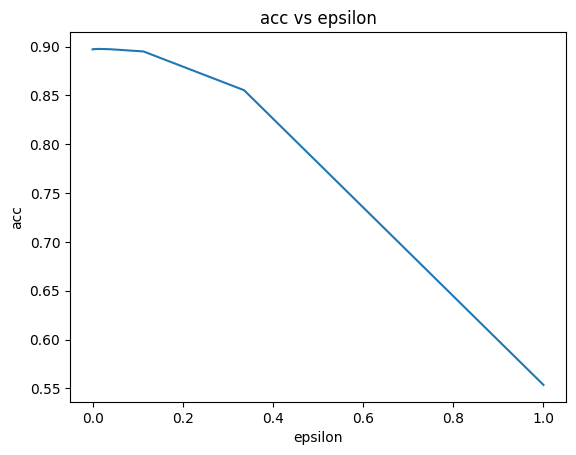

In [33]:
relu_simple_dnn_accs = evaluate_robustness(relu_simple_dnn, noise, epsilons, test_ds)
plot_scalars(relu_simple_dnn_accs, epsilons, 'acc', 'epsilon')

/tmp/ipykernel_98836/2973515693.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (x.float() + self.epsilon * self.noise).float()


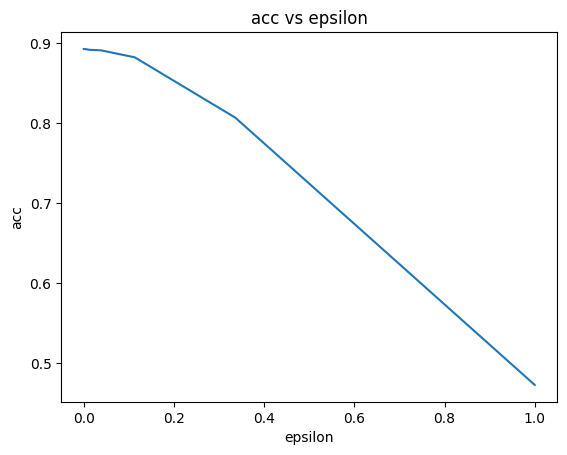

In [34]:
relu_complex_dnn_accs = evaluate_robustness(relu_complex_dnn, noise, epsilons, test_ds)
plot_scalars(relu_complex_dnn_accs, epsilons, 'acc', 'epsilon')

/tmp/ipykernel_98836/2973515693.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (x.float() + self.epsilon * self.noise).float()


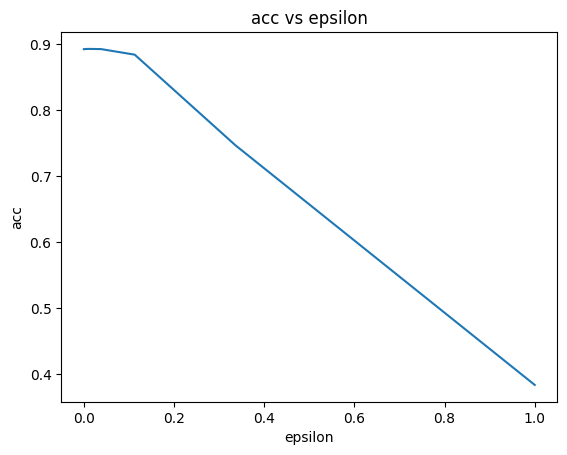

In [35]:
sigmoid_dnn_accs = evaluate_robustness(sigmoid_dnn, noise, epsilons, test_ds)
plot_scalars(sigmoid_dnn_accs, epsilons, 'acc', 'epsilon')

In [36]:
class NoiseTransform(torch.nn.Module):
    def __init__(self, epsilon=0.1):
      super().__init__()
      self.epsilon = epsilon

    def forward(self, x):
      noise = np.random.rand(28, 28)
      return (x.float() + self.epsilon * noise).float()

In [37]:
transform = NoiseTransform(epsilon=0.001)
model = ReLUComplexDNN()
noisy_train_ds = [(transform(img), label) for img, label in train_ds]
noisy_train_loader = DataLoader(noisy_train_ds, batch_size=32)

/tmp/ipykernel_98836/4170568771.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (x.float() + self.epsilon * noise).float()


In [38]:
n_epochs = 30
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [39]:
losses = train(noisy_train_loader, model, loss_fn, optimizer, n_epochs)

[Epoch 1] Loss: 2.3053763881259495
[Epoch 2] Loss: 2.298156479941474
[Epoch 3] Loss: 2.2900045263502333
[Epoch 4] Loss: 2.2794676168229846
[Epoch 5] Loss: 2.264665996975369
[Epoch 6] Loss: 2.2419887513054744
[Epoch 7] Loss: 2.203651183446248
[Epoch 8] Loss: 2.1337995584275986
[Epoch 9] Loss: 1.9996374368667602
[Epoch 10] Loss: 1.7662476541731094
[Epoch 11] Loss: 1.4819707763459948
[Epoch 12] Loss: 1.2454807965490553
[Epoch 13] Loss: 1.064967154926724
[Epoch 14] Loss: 0.9155650612513224
[Epoch 15] Loss: 0.798182221227222
[Epoch 16] Loss: 0.7152497846550412
[Epoch 17] Loss: 0.6568301629490323
[Epoch 18] Loss: 0.612893984635671
[Epoch 19] Loss: 0.5776338725090027
[Epoch 20] Loss: 0.5480934108495712
[Epoch 21] Loss: 0.522749834590488
[Epoch 22] Loss: 0.5009055278566149
[Epoch 23] Loss: 0.4819325391319063
[Epoch 24] Loss: 0.465352447019683
[Epoch 25] Loss: 0.45074984310732946
[Epoch 26] Loss: 0.4377368134525087
[Epoch 27] Loss: 0.4260199988749292
[Epoch 28] Loss: 0.41534785614411035
[Epoch 

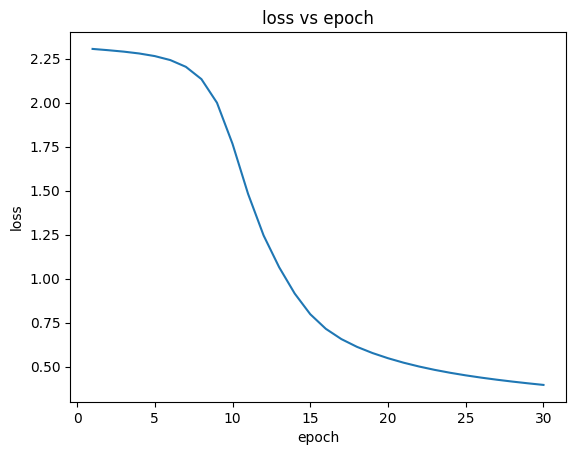

In [40]:
plot_scalars(losses)

In [41]:
noisy_test_ds = [(transform(img), label) for img, label in test_ds]
noisy_test_loader = DataLoader(noisy_test_ds, batch_size=32)
acc = evaluate_accuracy(model, noisy_test_loader)
acc

/tmp/ipykernel_98836/4170568771.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return (x.float() + self.epsilon * noise).float()


0.8822083333333334

## Exercise 4 - Robustness Against Noise

## Exercise 5 - Permutation Invariant

In [42]:
from torchvision.transforms import v2
from torchvision.transforms import Compose

class FixedPermutationTransform(torch.nn.Module):
    def __init__(self, permutation):
      super().__init__()
      self.permutation = permutation

    def forward(self, x):
      assert x.shape == (1,28,28), f"Received {x.shape}"
      x_flat = x.flatten()
      return x_flat[self.permutation].view(1, 28, 28)

In [43]:
permutation = torch.randperm(784)
transform = FixedPermutationTransform(permutation)
permuted_train_ds = [(transform(img), label) for img, label in train_ds]
permuted_test_ds = [(transform(img), label) for img, label in test_ds]
permuted_train_loader = DataLoader(permuted_train_ds, batch_size=32)
permuted_test_loader = DataLoader(permuted_test_ds, batch_size=32)

[Epoch 1] Loss: 2.1960550763871933
[Epoch 2] Loss: 1.9135222319497003
[Epoch 3] Loss: 1.5711015422609118
[Epoch 4] Loss: 1.2487366255654229
[Epoch 5] Loss: 1.010154865635766
[Epoch 6] Loss: 0.8499705144034492
[Epoch 7] Loss: 0.741847438732783
[Epoch 8] Loss: 0.6659258049594031
[Epoch 9] Loss: 0.6102854158613417
[Epoch 10] Loss: 0.5679652386241489
[Epoch 11] Loss: 0.5347800795899497
[Epoch 12] Loss: 0.5081042650408215
[Epoch 13] Loss: 0.4862146620750427
[Epoch 14] Loss: 0.4679407058027055
[Epoch 15] Loss: 0.4524578093290329
[Epoch 16] Loss: 0.43917149329185484
[Epoch 17] Loss: 0.4276398349205653
[Epoch 18] Loss: 0.4175262510975202
[Epoch 19] Loss: 0.4085705539186796
[Epoch 20] Loss: 0.40057694564263024
[Epoch 21] Loss: 0.39339136195845076
[Epoch 22] Loss: 0.3868853865000937
[Epoch 23] Loss: 0.3809566952917311
[Epoch 24] Loss: 0.37552361023426056
[Epoch 25] Loss: 0.3705160006549623
[Epoch 26] Loss: 0.3658819941414727
[Epoch 27] Loss: 0.36157422007454765
[Epoch 28] Loss: 0.357553279638290

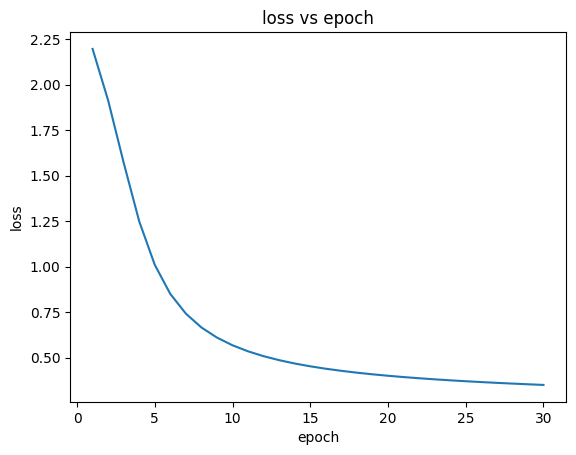

In [44]:
relu_simple_dnn_permuted = ReLUSimpleDNN()
loss_fn = torch.nn.CrossEntropyLoss() # applies softmax internally, expects logits
optimizer = torch.optim.SGD(relu_simple_dnn_permuted.parameters(), lr=1e-3)
losses = train(permuted_train_loader, relu_simple_dnn_permuted, loss_fn, optimizer, n_epochs)
plot_scalars(losses)
accuracy = evaluate_accuracy(relu_simple_dnn_permuted, permuted_test_loader)

In [45]:
accuracy

0.897625

* The modelling still works
* In a fully-connected DNN, every input feature is connected to every neuron in the next layer, so by simply learning the appropriate permutation function in the first layer, you can invert the original permutation.
* I am not claiming the model learns the inverse permutation in the first layer, but rather highlighting why it's possible for the model to achieve the same accuracy.
* In reality, the model likely learns the same weights in a permuted order, and this is possible because every input feature is connected to every neuron in the next layer.

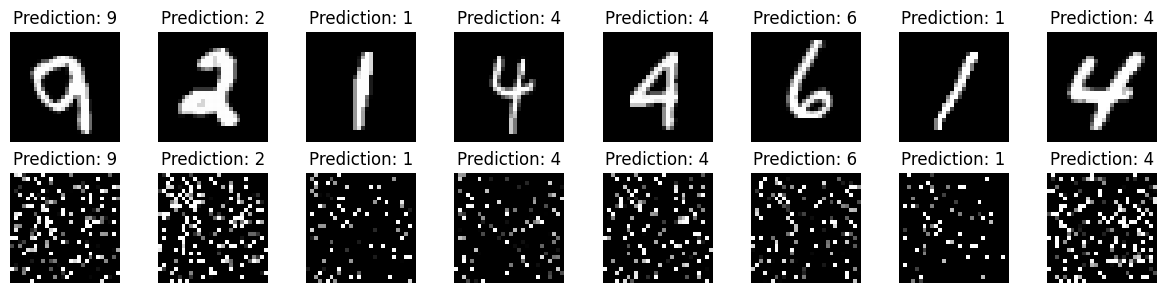

In [46]:
random_indices = random.sample(range(len(test_ds)), 8)

fig, axes = plt.subplots(2, 8, figsize=(12, 3))
relu_simple_dnn.eval()
relu_simple_dnn_permuted.eval()

with torch.no_grad():
  for col, index in enumerate(random_indices):
    image, label = test_ds[index]
    image = image.to(device)

    prediction = relu_simple_dnn(image)
    predicted_class = torch.argmax(prediction, dim=1).item()

    ax = axes[0, col]
    ax.imshow(image.cpu().squeeze(0), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Prediction: {predicted_class}")

    image, label = permuted_test_ds[index]
    image = image.to(device)

    prediction = relu_simple_dnn_permuted(image)
    predicted_class = torch.argmax(prediction, dim=1).item()

    ax = axes[1, col]
    ax.imshow(image.cpu().squeeze(0), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Prediction: {predicted_class}")

plt.tight_layout()
plt.show()

## Bonus:
**Goal:** Train a ReLU-based DNN on the dataset with a fixed ε, where noise n is generated for each image. Evaluate and report the accuracy of this network.

## Save Simple ReLU net to ONNX

In [50]:
example_inputs = (torch.randn(1, 28, 28, device=device),)
onnx_program = torch.onnx.export(relu_simple_dnn, example_inputs, dynamo=True)
onnx_program.optimize()
onnx_program.save("relu_dnn_mnist_classifier.onnx")

[torch.onnx] Obtain model graph for `ReLUSimpleDNN([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ReLUSimpleDNN([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


In [ ]:
from maraboupy import Marabou
import numpy as np

In [2]:
options = Marabou.createOptions(verbosity = 0)

In [ ]:
print("Fully Connected Network Example")
filename = "relu_dnn_mnist_classifier.onnx"
network = Marabou.read_onnx(filename=filename)

In [4]:
inputVars = network.inputVars[0][0]
outputVars = network.outputVars[0]

In [ ]:
outputVars